Using device: cuda
Time step: 1.55e-10 s


C:\Users\bashc\AppData\Local\Temp\ipykernel_28428\1854827780.py:113: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(electrode_A_np, levels=[0.5], colors='yellow', linewidths=2, label=f'Electrode A (V={V1} V)')
C:\Users\bashc\AppData\Local\Temp\ipykernel_28428\1854827780.py:114: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(electrode_B_np, levels=[0.5], colors='green', linewidths=2, label=f'Electrode B (V={V2} V)')


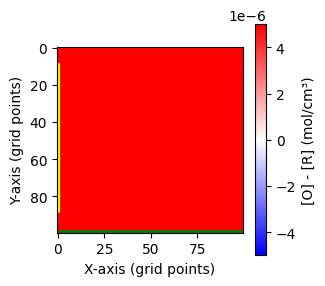

TypeError: diffusion_step() missing 3 required positional arguments: 'V1', 'electrode_B_mask', and 'V2'

In [62]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as Func

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

##################################################
# PARAMETERS
##################################################

# Concentration and diffusion parameters
concentration = 5e-6  # [mol/cm³] (converted from mol/L)
D = 0.726e-5          # [cm²/s] diffusion coefficient

# Electrode potentials
eta_A = 0.4           # [V] vs. reference electrode
eta_B = -0.4          # [V] vs. reference electrode

# Reaction parameters
n = 1.0               # [] number of electrons transferred
alpha = 0.51          # [] charge transfer coefficient
k0 = 1e-2             # [cm/s] electrochemical rate constant
kc = 1e-3             # [1/s] chemical rate constant

# Physical conditions
T = 298.15            # [K] temperature

# Simulation space parameters
sim_width = 100e-7    # [cm] width of simulation (converted from 100 nm)
sim_height = 100e-7   # [cm] height of simulation (converted from 100 nm)
grid_size = 100       # [] number of grid points in each dimension
gap_size = 11         # [] number of grid points for gap between electrodes

# Physical constants
Faraday = 96485.0     # [C/mol] Faraday's constant
R = 8.3145            # [J/(mol·K)] gas constant
normed_F = Faraday / (R * T)  # [1/V] normalized Faraday constant

# Simulation parameters
dx = sim_width / grid_size    # [cm] grid spacing in x-direction
dy = sim_height / grid_size   # [cm] grid spacing in y-direction
dt = 0.45 * min(dx, dy)**2 / (4 * D)  # [s] time step for stability
print(f"Time step: {dt:.2e} s")

##################################################
# SETUP GRID AND INITIAL CONDITIONS
##################################################
# Define the Laplacian kernel for 2D convolution


# Create grid
grid = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)

# Define electrode A position (left side)
left_electrode_width = 1  # Width of left electrode
left_electrode_start = 0  # Start of left electrode
left_electrode_end = left_electrode_start + left_electrode_width
left_electrode_height = int(grid_size * 0.8)
left_electrode_bottom = grid_size - left_electrode_height - gap_size

# Define electrode B position (bottom)
bottom_electrode_height = 1  # Height of bottom electrode
bottom_electrode_start = 0   # Start of bottom electrode
bottom_electrode_end = grid_size  # End of bottom electrode (full width)
bottom_electrode_top = grid_size - bottom_electrode_height

# Create masks for electrodes
electrode_A_mask = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)
electrode_B_mask = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)

# Set electrode A (left side)
electrode_A_mask[left_electrode_bottom:grid_size-gap_size, left_electrode_start:left_electrode_end] = True

# Set electrode B (bottom)
electrode_B_mask[bottom_electrode_top:, bottom_electrode_start:bottom_electrode_end] = True

# Combined electrode mask
electrodes_mask = electrode_A_mask | electrode_B_mask

# Initialize concentration fields
conc_O = torch.ones((grid_size, grid_size), dtype=torch.float32, device=device) * concentration
conc_R = torch.zeros((grid_size, grid_size), dtype=torch.float32, device=device)

def plotGrid(conc_O, conc_R, electrodes_mask,electrode_A_mask, V1,electrode_B_mask, V2):
    plt.figure(figsize=(3, 3))
    # Move data to CPU for plotting
    electrodes_np = electrodes_mask.cpu().numpy()
    conc_O_np = conc_O.cpu().numpy()
    conc_R_np = conc_R.cpu().numpy()

    # Create a custom colormap for the concentration difference
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    # Calculate the concentration difference
    concentration_difference = conc_O_np - conc_R_np

    # Plot the electrodes and concentration difference
    plt.imshow(concentration_difference, cmap=cmap, vmin=-concentration, vmax=concentration)
    plt.colorbar(label='[O] - [R] (mol/cm³)')
    
    plt.xlabel('X-axis (grid points)')
    plt.ylabel('Y-axis (grid points)')

    # Overlay the electrode positions with their respective voltages
    electrode_A_np = electrode_A_mask.cpu().numpy()
    electrode_B_np = electrode_B_mask.cpu().numpy()
    plt.contour(electrode_A_np, levels=[0.5], colors='yellow', linewidths=2, label=f'Electrode A (V={V1} V)')
    plt.contour(electrode_B_np, levels=[0.5], colors='green', linewidths=2, label=f'Electrode B (V={V2} V)')
    plt.show()
    
# Example usage
V1 = 0.4  # Voltage for Electrode A
V2 = -0.4  # Voltage for Electrode B
plotGrid(conc_O, conc_R, electrodes_mask,electrode_A_mask, V1,electrode_B_mask, V2)


def diffusion_step(conc_O, conc_R, dt, D, electrode_A_mask, V1,electrode_B_mask, V2):
    """
    Update the concentrations of species O and R due to diffusion over a time step.
    
    Parameters:
    -----------
    conc_O : torch.Tensor
        Concentration field of species O
    conc_R : torch.Tensor
        Concentration field of species R
    dt : float
        Time step [s]
    D : float
        Diffusion coefficient [cm²/s]
    electrodes_mask : torch.Tensor
        Boolean mask indicating electrode positions (where boundary conditions apply)
    
    Returns:
    --------
    conc_O_new : torch.Tensor
        Updated concentration field of species O
    conc_R_new : torch.Tensor
        Updated concentration field of species R
    """
    laplacian_kernel_2d = torch.tensor(
        [[[0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]]],
        dtype=torch.float32, device=device
    ).unsqueeze(0)  # Shape: (1, 1, 3, 3)
    
    def computeGradient(O):
        return Func.conv2d(O.unsqueeze(0).unsqueeze(0), laplacian_kernel_2d, padding=1).squeeze(0).squeeze(0)
    # Compute Laplacian for both species using the existing function
    laplacian_O = computeGradient(conc_O)
    laplacian_R = computeGradient(conc_R)
    
    # Update concentrations using explicit finite difference method
    # dc/dt = D * ∇²c
    conc_O_new = conc_O + dt * D * laplacian_O
    conc_R_new = conc_R + dt * D * laplacian_R
    
    
    
    return conc_O_new, conc_R_new

for i in range(20000):
    conc_O, conc_R=diffusion_step(conc_O, conc_R, dt, D, electrodes_mask)



Using device: cuda
Time step: 1.55e-02 s


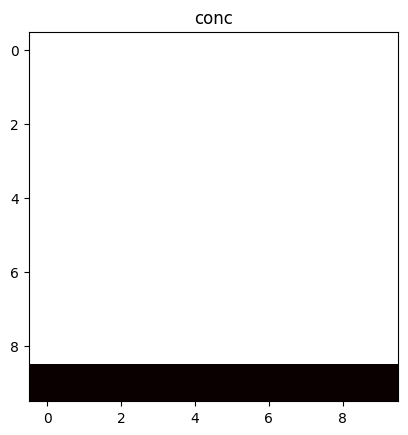

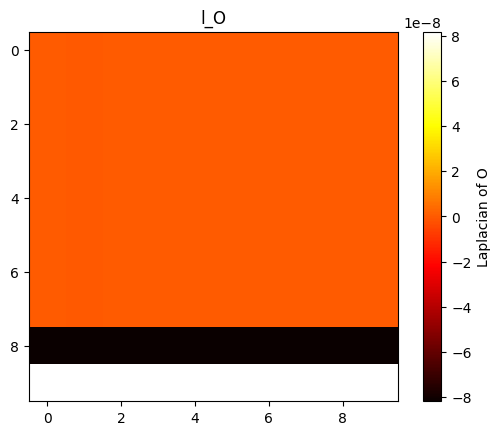

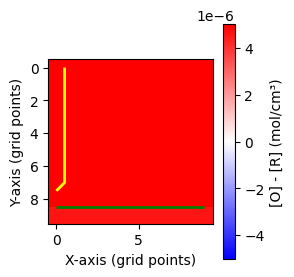

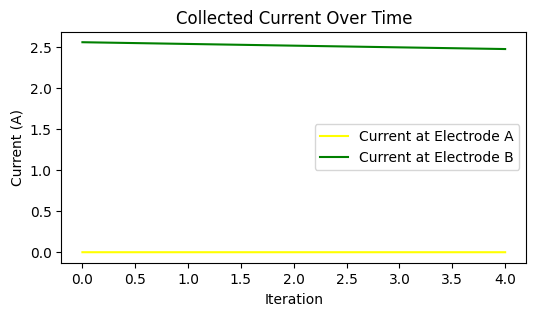

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as Func

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

##################################################
# PARAMETERS
##################################################

# Concentration and diffusion parameters
concentration = 5e-6  # [mol/cm³] (converted from mol/L)
D = 0.726e-5  # [cm²/s] diffusion coefficient

# Electrode potentials
pot_A = 0.2  # [V] vs. reference electrode
pot_B = -0.2  # [V] vs. reference electrode
E0 = 0  # [V] vs. reference electrode

# Reaction parameters
n = 1.0  # [] number of electrons transferred
alpha = 0.51  # [] charge transfer coefficient
k0 = 1e-2  # [cm/s] electrochemical rate constant
kc = 1e-3  # [1/s] chemical rate constant

# Physical conditions
T = 298.15  # [K] temperature

# Simulation space parameters
sim_width = 1e-2  # [cm] width of simulation (converted from 100 nm)
sim_height = 1e-2  # [cm] height of simulation (converted from 100 nm)
grid_size = 10  # [] number of grid points in each dimension
gap_size = 2  # [] number of grid points for gap between electrodes

# Physical constants
Faraday = 96485.0  # [C/mol] Faraday's constant
R = 8.3145  # [J/(mol·K)] gas constant
normed_F = Faraday / (R * T)  # [1/V] normalized Faraday constant

# Simulation parameters
dx = sim_width / grid_size  # [cm] grid spacing in x-direction
dy = sim_height / grid_size  # [cm] grid spacing in y-direction
dt = 0.45 * min(dx, dy) ** 2 / (4 * D)  # [s] time step for stability
print(f"Time step: {dt:.2e} s")

##################################################
# SETUP GRID AND INITIAL CONDITIONS
##################################################

# Create grid
grid = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)

# Define electrode A position (left side)
left_electrode_width = 1  # Width of left electrode
left_electrode_start = 0  # Start of left electrode
left_electrode_end = left_electrode_start + left_electrode_width
left_electrode_height = int(grid_size * 0.8)
left_electrode_bottom = grid_size - left_electrode_height - gap_size

# Define electrode B position (bottom)
bottom_electrode_height = 1  # Height of bottom electrode
bottom_electrode_start = 0  # Start of bottom electrode
bottom_electrode_end = grid_size  # End of bottom electrode (full width)
bottom_electrode_top = grid_size - bottom_electrode_height

# Create masks for electrodes
electrode_A_mask = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)
electrode_B_mask = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)

# Set electrode A (left side)
electrode_A_mask[
    left_electrode_bottom : grid_size - gap_size,
    left_electrode_start:left_electrode_end,
] = True

# Set electrode B (bottom)
electrode_B_mask[bottom_electrode_top:, bottom_electrode_start:bottom_electrode_end] = (
    True
)

# Combined electrode mask
electrodes_mask = electrode_A_mask | electrode_B_mask

# Initialize concentration fields
conc_O = (
    torch.ones((grid_size, grid_size), dtype=torch.float32, device=device)
    * concentration
)
conc_R = torch.zeros((grid_size, grid_size), dtype=torch.float32, device=device)





def plotGrid(
    conc_O,
    conc_R,
    electrodes_mask,
    electrode_A_mask,
    V1,
    electrode_B_mask,
    V2,
    iteration=None,
):
    plt.figure(figsize=(3, 3))
    # Move data to CPU for plotting
    conc_O_np = conc_O.cpu().numpy()
    conc_R_np = conc_R.cpu().numpy()

    # Create a custom colormap for the concentration difference
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

    # Calculate the concentration difference
    concentration_difference = conc_O_np - conc_R_np

    # Plot the electrodes and concentration difference
    plt.imshow(
        concentration_difference, cmap=cmap, vmin=-concentration, vmax=concentration
    )
    plt.colorbar(label="[O] - [R] (mol/cm³)")

    plt.xlabel("X-axis (grid points)")
    plt.ylabel("Y-axis (grid points)")

    # Overlay the electrode positions with their respective voltages
    electrode_A_np = electrode_A_mask.cpu().numpy()
    electrode_B_np = electrode_B_mask.cpu().numpy()
    plt.contour(electrode_A_np, levels=[0.5], colors="yellow", linewidths=2)
    plt.contour(electrode_B_np, levels=[0.5], colors="green", linewidths=2)

    # Add iteration information if provided
    if iteration is not None:
        plt.title(f"Iteration: {iteration}")

    plt.tight_layout()
    plt.show()


# Convert potentials to overpotentials
overpot_A = (pot_A - E0) * normed_F  # Convert to normalized overpotential
overpot_B = (pot_B - E0) * normed_F  # Convert to normalized overpotential

# Simulation loop parameters
num_iterations = 5  # Adjust for desired runtime
current_A = []
current_B = []

for t in range(num_iterations):
    # Apply Butler-Volmer kinetics to update concentrations at electrodes
    reaction_O_A = (
        -1*k0*dt*( conc_O[electrode_A_mask] * np.exp(-alpha * overpot_A) - conc_R[electrode_A_mask] * np.exp((1 - alpha) * overpot_A)        )
    )
    reaction_R_A = -reaction_O_A  # Conservation of species

    reaction_O_B = (
        -1* k0*dt*( conc_O[electrode_B_mask] * np.exp(-alpha * overpot_B) - conc_R[electrode_B_mask] * np.exp((1 - alpha) * overpot_B)       )
    )
    reaction_R_B = -reaction_O_B  # Conservation of species

    # Define Laplacian kernel for diffusion
    laplacian_kernel = (
        torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32, device=device)
        .unsqueeze(0)
        .unsqueeze(0)
    )

    def laplacian(concentration):
        padded_concentration = Func.pad(concentration.unsqueeze(0).unsqueeze(0), (1, 1, 1, 1), mode='replicate')
        return Func.conv2d(
            padded_concentration, laplacian_kernel
        ).squeeze()

    # Compute diffusion
    l_O = laplacian(conc_O)
    l_R = laplacian(conc_R)
    if t == 2:
        plt.title('conc')
        plt.imshow(conc_O.cpu().numpy(), cmap='hot')
        plt.show()
        plt.title('l_O')
        plt.imshow(l_O.cpu().numpy(), cmap='hot')
        plt.colorbar(label='Laplacian of O')
        plt.show()
    conc_O += D * l_O * dt
    conc_R += D * l_R * dt

    # Apply boundary conditions
    # Right side is infinite: set rightmost column equal to the second-to-last column
    conc_O[:, -1] = conc_O[:, -2]
    conc_R[:, -1] = conc_R[:, -2]
    conc_O[:, 0] = conc_O[:, 1]
    conc_R[:, 0] = conc_R[:, 1]

    # Top is open to bath: conc_O equals starting concentration, conc_R maintains slope
    conc_O[0, :] = concentration
    conc_R[0, :] = conc_R[1, :] * 0.95  # top is eventually 0 set a slope to remove concentration

    #conc_O[-1, :] = conc_O[-2, :]  # bottom is handled by change in concentration by electrode B
    #conc_R[-1, :] = conc_R[-2, :]

    conc_O[electrode_A_mask] += reaction_O_A
    conc_R[electrode_A_mask] += reaction_R_A

    conc_O[electrode_B_mask] += reaction_O_B
    conc_R[electrode_B_mask] += reaction_R_B

    # Integrate total current collected at each electrode
    j_A = -n * Faraday * reaction_O_A / dt
    j_B = -n * Faraday * reaction_O_B / dt

    # Integrate total current collected at each electrode
    current_A.append(torch.sum(j_A).item())
    current_B.append(torch.sum(j_B).item())

    # Periodic visualization
plotGrid(
    conc_O,
    conc_R,
    electrodes_mask,
    electrode_A_mask,
    overpot_A,
    electrode_B_mask,
    overpot_B,
)

# Plot collected currents
plt.figure(figsize=(6, 3))

plt.plot(current_A, label="Current at Electrode A", color="yellow")
plt.plot(current_B, label="Current at Electrode B", color="green")
plt.xlabel("Iteration")
plt.ylabel("Current (A)")
plt.legend()
plt.title("Collected Current Over Time")
plt.show()

Using device: cuda
Time step: 1.55e-02 s


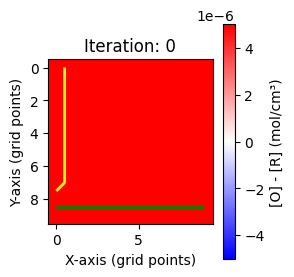

torch.Size([10, 10])
torch.Size([10, 10])


RuntimeError: The size of tensor a (8) must match the size of tensor b (10) at non-singleton dimension 0

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as Func

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

##################################################
# PARAMETERS
##################################################

# Concentration and diffusion parameters
concentration = 5e-6  # [mol/cm³] (converted from mol/L)
D = 0.726e-5          # [cm²/s] diffusion coefficient

# Electrode potentials
pot_A = -0.15           # [V] vs. reference electrode
pot_B = -0.25           # [V] vs. reference electrode
E0 = -.2                # [V] vs. reference electrode

# Reaction parameters
n = 1.0               # [] number of electrons transferred
alpha = 0.51          # [] charge transfer coefficient
k0 = 1e-2             # [cm/s] electrochemical rate constant
kc = 1e-3             # [1/s] chemical rate constant

# Physical conditions
T = 298.15            # [K] temperature

# Simulation space parameters
sim_width = 1e-2    # [cm] width of simulation (converted from 100 nm)
sim_height = 1e-2   # [cm] height of simulation (converted from 100 nm)
grid_size = 10       # [] number of grid points in each dimension
gap_size = 2         # [] number of grid points for gap between electrodes

# Physical constants
Faraday = 96485.0     # [C/mol] Faraday's constant
R = 8.3145            # [J/(mol·K)] gas constant
normed_F = Faraday / (R * T)  # [1/V] normalized Faraday constant

# Simulation parameters
dx = sim_width / grid_size    # [cm] grid spacing in x-direction
dy = sim_height / grid_size   # [cm] grid spacing in y-direction
dt = 0.45 * min(dx, dy)**2 / (4 * D)  # [s] time step for stability
print(f"Time step: {dt:.2e} s")

##################################################
# SETUP GRID AND INITIAL CONDITIONS
##################################################

# Create grid
grid = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)

# Define electrode A position (left side)
left_electrode_width = 1  # Width of left electrode
left_electrode_start = 0  # Start of left electrode
left_electrode_end = left_electrode_start + left_electrode_width
left_electrode_height = int(grid_size * 0.8)
left_electrode_bottom = grid_size - left_electrode_height - gap_size

# Define electrode B position (bottom)
bottom_electrode_height = 1  # Height of bottom electrode
bottom_electrode_start = 0   # Start of bottom electrode
bottom_electrode_end = grid_size  # End of bottom electrode (full width)
bottom_electrode_top = grid_size - bottom_electrode_height

# Create masks for electrodes
electrode_A_mask = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)
electrode_B_mask = torch.zeros((grid_size, grid_size), dtype=torch.bool, device=device)

# Set electrode A (left side)
electrode_A_mask[left_electrode_bottom:grid_size-gap_size, left_electrode_start:left_electrode_end] = True

# Set electrode B (bottom)
electrode_B_mask[bottom_electrode_top:, bottom_electrode_start:bottom_electrode_end] = True

# Combined electrode mask
electrodes_mask = electrode_A_mask | electrode_B_mask

# Initialize concentration fields
conc_O = torch.ones((grid_size, grid_size), dtype=torch.float32, device=device) * concentration
conc_R = torch.zeros((grid_size, grid_size), dtype=torch.float32, device=device)

def apply_boundary_conditions(conc_O, conc_R):
    # Maintain boundary conditions for conc_O and conc_R
    # Right side is infinite: set rightmost column equal to the second-to-last column
    conc_O[:, -1] = conc_O[:, -2]
    conc_R[:, -1] = conc_R[:, -2]
    
    conc_O[:, 0] = conc_O[:, 1]  # Left side is infinite: set leftmost column equal to the second column
    conc_R[:, 0] = conc_R[:, 1]  # Left side is infinite: set leftmost column equal to the second column    

    # Top is open to bath: conc_O equals starting concentration, conc_R maintains slope
    conc_O[0, :] = concentration
    conc_R[0, :] += (conc_R[2,:]-conc_R[1,:])*1.05  # Adjust to maintain concentration gradient
    
    conc_O[-1, :] = conc_O[-2, :]  # Bottom is open to bath: conc_O equals starting concentration
    conc_R[-1, :] = conc_R[-2, :]  # Adjust to maintain concentration gradient
    return conc_O, conc_R

def plotGrid(conc_O, conc_R, electrodes_mask, electrode_A_mask, V1, electrode_B_mask, V2, iteration=None):
    plt.figure(figsize=(3, 3))
    # Move data to CPU for plotting
    conc_O_np = conc_O.cpu().numpy()
    conc_R_np = conc_R.cpu().numpy()

    # Create a custom colormap for the concentration difference
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    # Calculate the concentration difference
    concentration_difference = conc_O_np - conc_R_np

    # Plot the electrodes and concentration difference
    plt.imshow(concentration_difference, cmap=cmap, vmin=-concentration, vmax=concentration)
    plt.colorbar(label='[O] - [R] (mol/cm³)')
    
    plt.xlabel('X-axis (grid points)')
    plt.ylabel('Y-axis (grid points)')

    # Overlay the electrode positions with their respective voltages
    electrode_A_np = electrode_A_mask.cpu().numpy()
    electrode_B_np = electrode_B_mask.cpu().numpy()
    plt.contour(electrode_A_np, levels=[0.5], colors='yellow', linewidths=2 )
    plt.contour(electrode_B_np, levels=[0.5], colors='green', linewidths=2 )
    
    # Add iteration information if provided
    if iteration is not None:
        plt.title(f'Iteration: {iteration}')
    
    plt.tight_layout()
    plt.show()

# Define the Butler-Volmer function for electrochemical reactions
def butler_volmer_reaction(conc_O, conc_R, eta, dt, k0, alpha, n, normed_F):
    """
    Apply Butler-Volmer equation to compute electrochemical reaction rates.
    
    Parameters:
    -----------
    conc_O : torch.Tensor
        Concentration of oxidized species [mol/cm³]
    conc_R : torch.Tensor
        Concentration of reduced species [mol/cm³]
    eta : float
        Overpotential [V]
    dt : float
        Time step [s]
    k0 : float
        Standard rate constant [cm/s]
    alpha : float
        Transfer coefficient []
    n : float
        Number of electrons []
    normed_F : float
        Normalized Faraday constant [1/V]
        
    Returns:
    --------
    delta_O : torch.Tensor
        Change in oxidized species concentration
    delta_R : torch.Tensor
        Change in reduced species concentration
    """
    # Calculate reduction rate (O + e- -> R)
    kred = k0 * np.exp(-alpha * n * normed_F * eta)
    
    # Calculate oxidation rate (R -> O + e-)
    kox = k0 * np.exp((1 - alpha) * n * normed_F * eta)
    
    # Calculate concentration changes
    delta_O = (-kred * conc_O + kox * conc_R) * dt
    delta_R = (kred * conc_O - kox * conc_R) * dt
    
    return delta_O, delta_R

def diffusion_step(conc_O, conc_R, dt, D, electrode_A_mask, V1, electrode_B_mask, V2, k0, alpha, n, normed_F):
    """
    Update the concentrations of species O and R due to diffusion and electrochemical reactions.
    
    Parameters:
    -----------
    conc_O : torch.Tensor
        Concentration field of species O
    conc_R : torch.Tensor
        Concentration field of species R
    dt : float
        Time step [s]
    D : float
        Diffusion coefficient [cm²/s]
    electrode_A_mask : torch.Tensor
        Boolean mask indicating electrode A positions
    V1 : float
        Potential at electrode A [V]
    electrode_B_mask : torch.Tensor
        Boolean mask indicating electrode B positions
    V2 : float
        Potential at electrode B [V]
    
    Returns:
    --------
    conc_O_new : torch.Tensor
        Updated concentration field of species O
    conc_R_new : torch.Tensor
        Updated concentration field of species R
    """
    laplacian_kernel_2d = torch.tensor(
        [[[0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]]],
        dtype=torch.float32, device=device
    ).unsqueeze(0)  # Shape: (1, 1, 3, 3)
    
    def computeGradient(O):
        return Func.conv2d(O.unsqueeze(0).unsqueeze(0), laplacian_kernel_2d, padding=1 ).squeeze(0).squeeze(0)
    
    # Update concentrations using explicit finite difference method for diffusion
   
    conc_O[1:-1] = conc_O[1:-1] + dt * D * computeGradient(conc_O)
    conc_R[1:-1] = conc_R[1:-1] + dt * D * computeGradient(conc_R)
    
    # Apply Butler-Volmer reaction at electrode A
    delta_O_A, delta_R_A = butler_volmer_reaction(
        conc_O[electrode_A_mask], 
        conc_R[electrode_A_mask], 
        V1, dt, k0, alpha, n, normed_F
    )
    
    # Apply Butler-Volmer reaction at electrode B
    delta_O_B, delta_R_B = butler_volmer_reaction(
        conc_O[electrode_B_mask], 
        conc_R[electrode_B_mask], 
        V2, dt, k0, alpha, n, normed_F
    )
    
    # Calculate current at electrode A
    current_A = n * Faraday * torch.sum(delta_R_A) / dt
    
    # Calculate current at electrode B
    current_B = n * Faraday * torch.sum(delta_R_B) / dt
    
    
    
    
    # Apply reaction changes to electrodes A and B
    conc_O[electrode_A_mask] += delta_O_A
    conc_R[electrode_A_mask] += delta_R_A
    conc_O[electrode_B_mask] += delta_O_B
    conc_R[electrode_B_mask] += delta_R_B
 
    return conc_O, conc_R,current_A.item(), current_B.item()

# Example usage - initial plot
V1 = eta_A  # Voltage for Electrode A
V2 = eta_B  # Voltage for Electrode B
plotGrid(conc_O, conc_R, electrodes_mask, electrode_A_mask, V1, electrode_B_mask, V2, iteration=0)

# Run simulation
num_iterations = 20000
plot_every = 5000  # Plot every 5000 iterations

currents_A = []
currents_B = []
for i in range(num_iterations):
    conc_O, conc_R, current_A, current_B = diffusion_step(
        conc_O, conc_R, dt, D, 
        electrode_A_mask, V1, electrode_B_mask, V2,
        k0, alpha, n, normed_F
    )
    
    currents_A.append(np.mean(np.abs(current_A)))
    currents_B.append(np.mean(np.abs(current_B)))
    
    # Plot at specified intervals
    if (i+1) % plot_every == 0 or i == num_iterations - 1 or True:
        
        fig, axs = plt.subplots(1, 3, figsize=(9, 3))

        # Plot concentration of R
        conc_R_np = conc_R.cpu().numpy()
        im1 = axs[0].imshow(conc_R_np, cmap='Blues', vmin=0, vmax=concentration)
        axs[0].set_title('Concentration of R (Reduced Species)')
        axs[0].set_xlabel('X-axis (grid points)')
        axs[0].set_ylabel('Y-axis (grid points)')
        fig.colorbar(im1, ax=axs[0], label='[R] (mol/cm³)')

        # Plot concentration of O
        conc_O_np = conc_O.cpu().numpy()
        im2 = axs[1].imshow(conc_O_np, cmap='Reds', vmin=0, vmax=concentration)
        axs[1].set_title('Concentration of O (Oxidized Species)')
        axs[1].set_xlabel('X-axis (grid points)')
        axs[1].set_ylabel('Y-axis (grid points)')
        fig.colorbar(im2, ax=axs[1], label='[O] (mol/cm³)')

        # Plot currents on each electrode
        axs[2].semilogy(currents_A, label='Current A')
        axs[2].semilogy(currents_B, label='Current B')
        axs[2].set_title('Current on Each Electrode')
        axs[2].set_xlabel('Iteration')
        axs[2].set_ylabel('Current [A]')
        axs[2].legend()

        plt.tight_layout()
        plt.show()
        print(f"Completed iteration {i+1}/{num_iterations}")
        if i==2:
            break 